<a href="https://colab.research.google.com/github/lucash-h/Manifold-Guided-GAN/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
import time
from tensorflow.keras.layers import Input, Dense, Conv2D, UpSampling2D, Dropout, Reshape, MaxPooling2D
from tensorflow.keras.layers import Flatten, LeakyReLU, ReLU, Conv2DTranspose, Concatenate,  BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

from tqdm import tqdm


In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

train_set = tf.reshape(train_images, (1875, 32, 28,28,1))

#train_set = tf.data.Dataset.from_tensor_slices((train_images))
#train_set = train_set.shuffle(buffer_size=train_images.shape[0]).batch(32)

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
# define GAN architectures

def build_pixel_discriminator():
  xin = Input((28,28,1))
  x0 = Conv2D(filters = 16, kernel_size=3, padding="same",activation='swish')(xin)
  x0 = Conv2D(filters = 32, kernel_size=3, padding="same",activation='swish')(x0)
  x0 = MaxPooling2D()(x0)
  x0 = Flatten()(x0)
  x0 = Dropout(0.4)(x0)
  x0 = Dense(1, activation = 'sigmoid')(x0)
  return Model(xin,x0)

def build_generator(input_shape = 100):
  xin = Input((input_shape,))
  x0 = Dense((7*7*4))(xin)
  x0 = Reshape((7,7,4))(x0)

  x0 = UpSampling2D()(x0) # 14x14
  x0 = Conv2D(filters = 64, kernel_size=3, padding = "same",activation='swish')(x0)
  x0 = Conv2D(filters = 64, kernel_size=3, padding = "same",activation='swish')(x0)
  x0 = UpSampling2D()(x0) # 28x28
  x0 = Conv2D(filters = 64, kernel_size=3, padding = "same",activation='swish')(x0)
  x0 = Conv2D(filters = 64, kernel_size=3, padding = "same",activation='swish')(x0)
  x0 = Conv2D(filters = 1, kernel_size=1, activation = 'sigmoid')(x0)

  return Model(xin,x0)

In [ ]:
bce = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)

class gan:
  def __init__(self, generator, pixel_discriminator, fast_train = True):

    self.generator = generator
    self.pixel_discriminator = pixel_discriminator
    self.fast_train = fast_train

  def train(self, training_data, epochs=10, gen_optimizer = None, pixel_optimizer = None, latent_optimizer = None):
    # log loss values and things
    self.loss_log = {'gen_loss':[],
                     'pixel_loss':[],
                     'pixel_real_bin_acc':[],
                     'pixel_fake_bin_acc':[]}

    _batch_size = training_data.shape[1]
    real_labels = tf.zeros(_batch_size)
    fake_labels = tf.ones(_batch_size)

    self.pixel_discriminator.compile(metrics=['binary_accuracy'])

    # training_data must be in batches !
    for _epoch in range(epochs):
      print(f'beginning epoch {_epoch}')

      for idx, _batch in enumerate(training_data):

        # noise for generator
        _input_noise = tf.random.normal((_batch_size, self.generator.input.shape[1]))

        # train generator
        if self.fast_train:
          total_gen_loss, generated_images = self.calc_gen_loss(noise = _input_noise,
                                                                gen_optimizer = gen_optimizer,
                                                                real_labels = real_labels)
        else:
          with tf.GradientTape() as gen_tape:
            # prepare data
            generated_images  = self.generator(_input_noise)
            # send through discriminator
            pixel_fake_pred    = self.pixel_discriminator(generated_images)
            # calculate losses
            total_gen_loss   = bce( real_labels, pixel_fake_pred   )

          grads = gen_tape.gradient(total_gen_loss, self.generator.trainable_variables)
          gen_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))
        self.loss_log['gen_loss'].append(total_gen_loss.numpy())

        # train pixel discriminator
        if self.fast_train:
          total_pixel_loss = self.calc_pixel_loss(real = _batch,
                                                  fake = generated_images,
                                                  pixel_optimizer = pixel_optimizer,
                                                  real_labels = real_labels,
                                                  fake_labels = fake_labels)
        else:
          with tf.GradientTape() as pixel_tape:
            pixel_real_pred   = self.pixel_discriminator(_batch)
            pixel_fake_pred   = self.pixel_discriminator(generated_images) # from generator training <<
            # calculate losses
            pixel_loss_real  = bce( real_labels, pixel_real_pred)
            pixel_loss_fake  = bce( fake_labels, pixel_fake_pred)
            total_pixel_loss = pixel_loss_real + pixel_loss_fake
          grads = pixel_tape.gradient(total_pixel_loss, self.pixel_discriminator.trainable_variables)
          pixel_optimizer.apply_gradients(zip(grads, self.pixel_discriminator.trainable_variables))
        self.loss_log['pixel_loss'].append(total_pixel_loss.numpy())

        #logging accuracies
        if idx % 49 == 0:
          _, disc_x_real_bin_acc = self.pixel_discriminator.evaluate( _batch,  real_labels, verbose=0)
          _, disc_x_fake_bin_acc = self.pixel_discriminator.evaluate( generated_images,  fake_labels, verbose=0)

          self.loss_log['pixel_real_bin_acc'].append(disc_x_real_bin_acc)
          self.loss_log['pixel_fake_bin_acc'].append(disc_x_fake_bin_acc)

  @tf.function()
  def calc_pixel_loss(self,real,fake,pixel_optimizer,real_labels,fake_labels):
    # train pixel discriminator
    with tf.GradientTape() as pixel_tape:
      pixel_real_pred   = self.pixel_discriminator(real)
      pixel_fake_pred   = self.pixel_discriminator(fake)
      # calculate losses
      pixel_loss_real  = bce( real_labels, pixel_real_pred)
      pixel_loss_fake  = bce( fake_labels, pixel_fake_pred)
      total_pixel_loss = pixel_loss_real + pixel_loss_fake
    grads = pixel_tape.gradient(total_pixel_loss, self.pixel_discriminator.trainable_variables)
    pixel_optimizer.apply_gradients(zip(grads, self.pixel_discriminator.trainable_variables))

    return total_pixel_loss

  @tf.function()
  def calc_gen_loss(self,noise,gen_optimizer,real_labels):
    with tf.GradientTape() as gen_tape:
      # prepare data
      generated_images  = self.generator(noise)
      # send through discriminators
      pixel_fake_pred    = self.pixel_discriminator(generated_images)
      # calculate losses
      total_gen_loss   = bce( real_labels, pixel_fake_pred   )
    grads = gen_tape.gradient(total_gen_loss, self.generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

    return total_gen_loss, generated_images

In [ ]:
# initialize the GAN
mygan = gan(generator = build_generator(),
            pixel_discriminator = build_pixel_discriminator())


In [ ]:
# train both models of the GAN
mygan.train(training_data = tf.reshape(train_images, (1875,32,28,28,1)),
            epochs = 10,
            gen_optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-5),
            pixel_optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-5))

beginning epoch 0
beginning epoch 1
beginning epoch 2
beginning epoch 3
beginning epoch 4
beginning epoch 5
beginning epoch 6
beginning epoch 7
beginning epoch 8
beginning epoch 9


In [ ]:
# generate images
n_generated_samples = 64
generated = mygan.generator(tf.random.normal((n_generated_samples,100)))


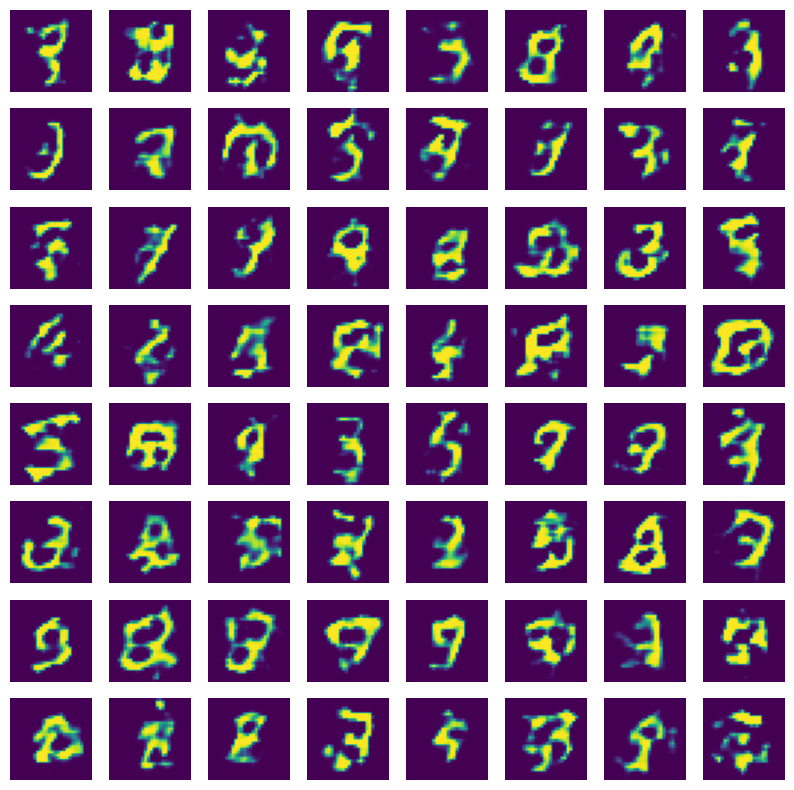

In [ ]:
 # visualize generated images

samples = 64
_edge_length = int(np.sqrt(samples))
fig,ax = plt.subplots(nrows = _edge_length, ncols = _edge_length,figsize=(10,10))
for i in range(_edge_length**2):
  ax[i//_edge_length][i%_edge_length].imshow(generated[i, :, :, 0])
  ax[i//8][i%8].axis('off')


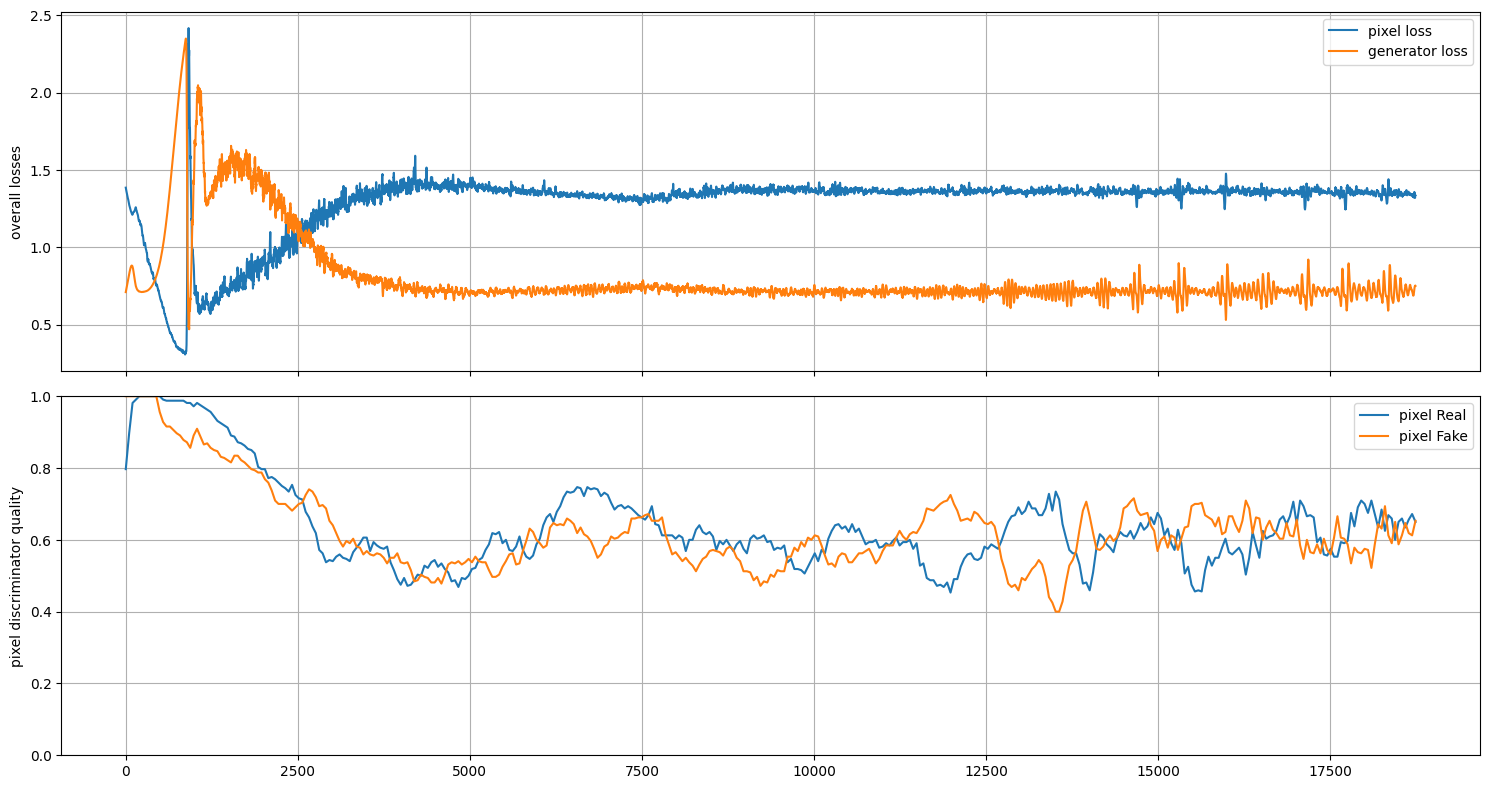

In [ ]:
def moving_avg(data, window):
    cumsum = np.cumsum(np.insert(data, 0, 0))
    return (cumsum[window:] - cumsum[:-window]) / float(window)

# -- make it pretty --
n_iterations = moving_avg(mygan.loss_log['gen_loss'], 10).shape[0]
moving_av_pixel_loss_real = moving_avg(mygan.loss_log['pixel_real_bin_acc'], 10)
moving_av_pixel_loss_fake = moving_avg(mygan.loss_log['pixel_fake_bin_acc'], 10)

# -- plot it --
fig, ax = plt.subplots(2,1, figsize = (15,8), sharex=True)

ax[0].plot(moving_avg(mygan.loss_log['pixel_loss'], 10), label = 'pixel loss')
ax[0].plot(moving_avg(mygan.loss_log['gen_loss'], 10), label = 'generator loss')
ax[0].legend()
ax[0].grid()
ax[0].set_ylabel('overall losses')

ax[1].plot(np.linspace(0,n_iterations, len(moving_av_pixel_loss_real)), moving_av_pixel_loss_real, label = 'pixel Real')
ax[1].plot(np.linspace(0,n_iterations, len(moving_av_pixel_loss_fake)), moving_av_pixel_loss_fake, label = 'pixel Fake')
ax[1].grid()
ax[1].legend()
ax[1].set_ylabel('pixel discriminator quality')
ax[1].set_ylim(0,1)

plt.tight_layout()